## MCA of twitter data

## Import required python libraries

In [1]:

from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import pyap
from nltk import ngrams
from itertools import chain
import tables
from google.cloud import bigquery
from datetime import datetime, timedelta
import time
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import os.path
pd.options.display.max_colwidth = 500
import collections
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis.sklearn
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.gensim  
from pprint import pprint
import gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

/opt/conda/lib/python3.7/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/opt/conda/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Parameter list from user

In [12]:
# Data cleanning: words to ignore; as the texts are about roof ignoring them
mystopwords=['rt','https','cc','one','amp','thru','see','going','got','day','know','youre','gonna','thats']      

weather = ["rain", "hail", "tornado", "twister", "hurricane"]
business = ["roof", "roofing", "leak", "shingles", "metal roofs", "asphalt shingles","roofing","roof","RoofingContractors",
            "roofers","house","building","price","pricing", "buy new house", "estimate",]
others = ["isnpection", "maintanance", "quote", 
          "covid19", 'virus', 'coronavirus', 'corona virus', 'pandemic', 'corona', 'covid']
good_feelings=['like','good','right','love','well']
bad_feelings=['anxiety','cant','dont']

usa_locations=['United States','USA',
'Alabama','AL','Montana','MT',
'Alaska','AK','Nebraska','NE',
'Arizona','AZ','Nevada','NV',
'Arkansas','AR','New Hampshire','NH',
'California','CA','New Jersey','NJ',
'Colorado','CO','New Mexico','NM',
'Connecticut','CT','New York','NY',
'Delaware','DE','North Carolina','NC',
'Florida','FL','North Dakota','ND',
'Georgia','GA','Ohio','OH',
'Hawaii','HI','Oklahoma','OK',
'Idaho','ID','Oregon','OR',
'Illinois','IL','Pennsylvania','PA',
'Indiana','IN','Rhode Island','RI',
'Iowa','IA','South Carolina','SC',
'Kansas','KS','South Dakota','SD',
'Kentucky','KY','Tennessee','TN',
'Louisiana','LA','Texas','TX',
'Maine','ME','Utah','UT',
'Maryland','MD','Vermont','VT',
'Massachusetts','MA','Virginia','VA',
'Michigan','MI','Washington','WA',
'Minnesota','MN','West Virginia','WV',
'Mississippi','MS','Wisconsin','WI',
'Missouri','MO','Wyoming','WY']


usa_states_dict={'alabama':'AL','montana':'MT',
'alaska':'AK','nebraska':'NE',
'arizona':'AZ','nevada':'NV',
'arkansas':'AR','new hampshire':'NH',
'california':'CA','new jersey':'NJ',
'colorado':'CO','new mexico':'NM',
'connecticut':'CT','new york':'NY',
'delaware':'DE','north carolina':'NC',
'florida':'FL','north dakota':'ND',
'georgia':'GA','ohio':'OH',
'hawaii':'HI','oklahoma':'OK',
'idaho':'ID','oregon':'OR',
'illinois':'IL','pennsylvania':'PA',
'indiana':'IN','rhode island':'RI',
'iowa':'IA','south carolina':'SC',
'kansas':'KS','south dakota':'SD',
'kentucky':'KY','tennessee':'TN',
'louisiana':'LA','texas':'TX',
'maine':'ME','utah':'UT',
'maryland':'MD','vermont':'VT',
'massachusetts':'MA','virginia':'VA',
'michigan':'MI','washington':'WA',
'minnesota':'MN','west virginia':'WV',
'mississippi':'MS','wisconsin':'WI',
'missouri':'MO','wyoming':'WY'}

usa_country=['United States','USA','united states of america']

usa_states=['Alabama','AL','Montana','MT',
'Alaska','AK','Nebraska','NE',
'Arizona','AZ','Nevada','NV',
'Arkansas','AR','New Hampshire','NH',
'California','CA','New Jersey','NJ',
'Colorado','CO','New Mexico','NM',
'Connecticut','CT','New York','NY',
'Delaware','DE','North Carolina','NC',
'Florida','FL','North Dakota','ND',
'Georgia','GA','Ohio','OH',
'Hawaii','HI','Oklahoma','OK',
'Idaho','ID','Oregon','OR',
'Illinois','IL','Pennsylvania','PA',
'Indiana','IN','Rhode Island','RI',
'Iowa','IA','South Carolina','SC',
'Kansas','KS','South Dakota','SD',
'Kentucky','KY','Tennessee','TN',
'Louisiana','LA','Texas','TX',
'Maine','ME','Utah','UT',
'Maryland','MD','Vermont','VT',
'Massachusetts','MA','Virginia','VA',
'Michigan','MI','Washington','WA',
'Minnesota','MN','West Virginia','WV',
'Mississippi','MS','Wisconsin','WI',
'Missouri','MO','Wyoming','WY']

usa_cities=['Los Angeles','California','New York','Texas','Chicago','Washington','Houston',
 'San Francisco','Atlanta','Seattle','Brooklyn','Boston','Dallas','Michigan','Las Vegas','Austin','Pennsylvania',
 'New Jersey','Philadelphia','San Diego','Miami','Denver','NYC']


## Read from bigquery

In [13]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))
# read data
query = """
    select * FROM `gaf-np-ds.twitter_analysis.twitter_data_clean`  
"""
raw_data = pd.read_gbq(query, dialect='standard')
raw_data.shape

Client creating using default project: gaf-np-ds


Downloading: 100%|██████████| 65592/65592 [00:09<00:00, 7270.50rows/s]


(65592, 15)

In [14]:
print('Total no of data',raw_data.shape[0])
print('No of data where user location available',sum(list(raw_data['user_location'].value_counts())))
#print('No of data where user location United States',raw_data[raw_data.user_location.str.contains('|'.join(usa_locations),na=False)].shape[0])
print('No of unique text ',raw_data.drop_duplicates(['text']).shape[0])
unique_text=raw_data.drop_duplicates(['text'])
#print('No of texts with roof in unique text',unique_text[unique_text.text.str.contains('|'.join(['roof']))].shape[0])

Total no of data 65592
No of data where user location available 33475
No of unique text  57801


In [15]:
#list(data['user_location'].value_counts().index)


## Apply required extra filter on downloaded data from twitter
#### Filter data where user_location 'USA' or blank


In [16]:
textdata=raw_data[raw_data.user_location.str.contains('|'.join(usa_locations),na=False)]
textdatanull=raw_data[raw_data['user_location'].isna()]
textdata=pd.concat([textdata,textdatanull])


print(textdata.shape)

(64307, 15)


In [17]:
# we can get only last 1 week data
#temp=data.copy()
#temp['Created_dt']=temp['Created'].apply(lambda x: pd.to_datetime(x).date())
#temp=temp[temp['Created_dt'].astype('str')=='2020-04-19']
#temp=temp.drop_duplicates(subset={'text'})

## Cleanning text data before getting insights

In [18]:
# Display one duplicate
print(textdata.sort_values('text')['text'][:5])  # some instances of duplicate
print('no of unique sentences',len(textdata['text'].unique()))

12774                                                       aaaaaaagh hype levels roof
43967             aaaaaaand goes fourth wall least nicole falls roof itll slide rather
22174    aaaah umbrella soooo tearjerker also sadaharu overgrown kagura stays top roof
8025                                                   aaaand goes anxiety levels roof
46632                                                    aaaand goes shaman bitch roof
Name: text, dtype: object
no of unique sentences 56725


#### Remove duplicate text, convert to lowercase, create a column with the hashtag used

In [19]:
# Drop duplicate
textdata=textdata.copy()

textdata=textdata.drop_duplicates(subset={'text'})
print(textdata.shape)

#convert to lower
textdata['text']=textdata['text'].apply(lambda x: x.lower() if pd.notnull(x) else '').copy()


(56725, 15)


In [20]:
# remove words covid related as those are dominating string
#textdata=textdata.copy()
#textdata = textdata[~textdata.text.str.contains('|'.join(excludewords))]
#print('Shape of df',textdata.shape)                    

In [21]:
textdata['text'].head(5)

0                                                                  start roof
1                                                 homemade stuff roof friends
2    sandy hook mother emanuel charleston dylan roof trayvon martin shootings
3                                       wanna sit roof somebody talk whatever
4                                           construction software ipo delayed
Name: text, dtype: object

#### Remove website names, remove the names whome text was retweeted, removed punctuations, digits, removed english stopwords, kept only alphabetic chracters, used lemmetization(original form of words : cats--> cat)

In [22]:
textdata=textdata.copy()

#remove website name
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
                                        
#remove RT retweet to subject
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'@(\w+)', r'', x))

# clean punc
def cleanpuncdigit(sentence):
    cleaned=re.sub(r'[-|\|(|)|.|,|:|/|?|!|"|#]',r' ',sentence)
    cleaned=re.sub(r'[\d+]',r' ',cleaned)    
    cleaned=re.sub(r'[\'|’]',r'',cleaned)    #won't wont
    return cleaned
textdata['text']=textdata['text'].apply(cleanpuncdigit)

#remove stopwords
stop=set(stopwords.words('english'))
stop.update(mystopwords)
textdata['text']=textdata['text'].apply(lambda x : ' '.join([item for item in x.split() if item not in stop]))

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words before stem',len(set([item for sublist in l for item in sublist])))

# Stemming this is not giving correct words so commenting
#sno=nltk.stem.snowball.SnowballStemmer('english')
#textdata['text'] = textdata['text'].apply(lambda x: ' '.join([sno.stem(y) for y in x.split()])) # Stem every word.
#sno.stem('coming come programers programer, programming going')

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words after stemming',len(set([item for sublist in l for item in sublist])))

# keep only alphabetic character remove whitespace
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'[^A-Za-z]', ' ', x))
textdata['text']=textdata['text'].apply(lambda x: x.strip())

# Lemmetization we are removing for now
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])
#textdata['text']=textdata['text'].apply(lemmatize_text)

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words after lemetization',len(set([item for sublist in l for item in sublist])))

#remove words with len<2
textdata['text']=textdata['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

No of unique words before stem 38367
No of unique words after stemming 38367
No of unique words after lemetization 38367


In [23]:
l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words',len(set([item for sublist in l for item in sublist])))

No of unique words 38367


In [24]:
textdata['text'].head(10)

0                                                                  start roof
1                                                 homemade stuff roof friends
2    sandy hook mother emanuel charleston dylan roof trayvon martin shootings
3                                       wanna sit roof somebody talk whatever
4                                           construction software ipo delayed
5                                                      havent roof quarentine
6                        pigeons roof like ghost dawg deight howard post dawg
7                 hell yeah fasho camera angles notice camera man jumped roof
8              street roof view ndstreet chryslerbuilding chryslerbuildingnyc
9                                                     would send anxiety roof
Name: text, dtype: object

#### Filter the texts with word roof


In [25]:
textdata[textdata.text.str.contains('|'.join(['roof','roofing']))]['text'].head(5)


0                                                                  start roof
1                                                 homemade stuff roof friends
2    sandy hook mother emanuel charleston dylan roof trayvon martin shootings
3                                       wanna sit roof somebody talk whatever
5                                                      havent roof quarentine
Name: text, dtype: object

## Word frequency

In [26]:
pd.Series(' '.join(textdata.text).split()).value_counts()[:50]


roof        53215
like         3328
roofing      3188
get          2532
anxiety      2418
head         2407
house        1865
new          1820
dont         1795
would        1744
top          1627
mouth        1582
time         1524
people       1454
today        1451
need         1450
home         1236
food         1213
good         1205
right        1197
back         1113
love         1066
cant         1064
work         1028
want         1006
think        1001
put           992
car           973
still         963
really        934
keep          916
jump          894
make          875
building      805
rain          795
even          774
live          752
could         749
well          748
last          744
went          741
shit          733
take          732
man           727
every         714
getting       712
lol           705
family        705
sun           705
tin           701
dtype: int64

#### Create business, weather, others column and ultimately create crosstab

In [27]:
def unique_col(col):
    return ','.join(set(col.split(',')))

temp = textdata.text.str.findall('(' + '|'.join(weather) + ')', flags=re.IGNORECASE),
#print(temp)
textdata["weather"] = temp[0].str.join(',')
textdata['weather'] = textdata.weather.apply(unique_col)
textdata.head(2)


,Author,Screenname,Created,text,place_name,country,place_type,user_location,user_geo_loc,tag,reply_to,Sentiment,rating,state_extracted,country_extracted,weather
0,sweeterman,damydothedishes,2020-04-30 14:16:29,start roof,None,None,None,ATX,None,[],[],neutral,0.0,None,None,
1,Ahmed,Asheihab,2020-04-30 19:56:39,homemade stuff roof friends,None,None,None,CAI,None,[],['hawtstuffdotcom'],neutral,0.0,None,None,


In [28]:
temp = textdata.text.str.findall('(' + '|'.join(business) + ')', flags=re.IGNORECASE),
textdata["business"] = temp[0].str.join(',')
textdata['business'] = textdata.business.apply(unique_col)
textdata.head(2)


,Author,Screenname,Created,text,place_name,country,place_type,user_location,user_geo_loc,tag,reply_to,Sentiment,rating,state_extracted,country_extracted,weather,business
0,sweeterman,damydothedishes,2020-04-30 14:16:29,start roof,None,None,None,ATX,None,[],[],neutral,0.0,None,None,,roof
1,Ahmed,Asheihab,2020-04-30 19:56:39,homemade stuff roof friends,None,None,None,CAI,None,[],['hawtstuffdotcom'],neutral,0.0,None,None,,roof


In [29]:

temp = textdata.text.str.findall('(' + '|'.join(good_feelings) + ')', flags=re.IGNORECASE), 
textdata["good"] = temp[0].str.join(',')
textdata['good'] = textdata.good.apply(unique_col)
textdata.head(2)

temp = textdata.text.str.findall('(' + '|'.join(bad_feelings) + ')', flags=re.IGNORECASE), 
textdata["bad"] = temp[0].str.join(',')
textdata['bad'] = textdata.bad.apply(unique_col)
textdata.head(2)


,Author,Screenname,Created,text,place_name,country,place_type,user_location,user_geo_loc,tag,reply_to,Sentiment,rating,state_extracted,country_extracted,weather,business,good,bad
0,sweeterman,damydothedishes,2020-04-30 14:16:29,start roof,None,None,None,ATX,None,[],[],neutral,0.0,None,None,,roof,,
1,Ahmed,Asheihab,2020-04-30 19:56:39,homemade stuff roof friends,None,None,None,CAI,None,[],['hawtstuffdotcom'],neutral,0.0,None,None,,roof,,


In [30]:
temp = textdata.text.str.findall('(' + '|'.join(others) + ')', flags=re.IGNORECASE), 
textdata["others"] = temp[0].str.join(',')
textdata['others'] = textdata.others.apply(unique_col)
textdata.head(2)

,Author,Screenname,Created,text,place_name,country,place_type,user_location,user_geo_loc,tag,reply_to,Sentiment,rating,state_extracted,country_extracted,weather,business,good,bad,others
0,sweeterman,damydothedishes,2020-04-30 14:16:29,start roof,None,None,None,ATX,None,[],[],neutral,0.0,None,None,,roof,,,
1,Ahmed,Asheihab,2020-04-30 19:56:39,homemade stuff roof friends,None,None,None,CAI,None,[],['hawtstuffdotcom'],neutral,0.0,None,None,,roof,,,


In [342]:
business_df = textdata[['text','business']]
business_df = business_df.drop_duplicates(['text'])
business_df = business_df.set_index(['text'])
business_df = business_df.stack().str.split(',', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index()
print(business_df.head(2))

weather_df = textdata[['text','weather']]
weather_df = weather_df.drop_duplicates(['text'])
weather_df = weather_df.set_index(['text'])
weather_df = weather_df.stack().str.split(',', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index()

others_df = textdata[['text','others']]
others_df = others_df.drop_duplicates(['text'])
others_df = others_df.set_index(['text'])
others_df = others_df.stack().str.split(',', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index()

good_df = textdata[['text','good']]
good_df = good_df.drop_duplicates(['text'])
good_df = good_df.set_index(['text'])
good_df = good_df.stack().str.split(',', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index()


bad_df = textdata[['text','bad']]
bad_df = bad_df.drop_duplicates(['text'])
bad_df = bad_df.set_index(['text'])
bad_df = bad_df.stack().str.split(',', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index()



                          text business
0                   start roof     roof
1  homemade stuff roof friends     roof


In [343]:
from functools import reduce
final_df = reduce(lambda x,y: pd.merge(x,y, on=['text'], how='outer'),
       [weather_df, business_df, others_df,good_df,bad_df])

final_df.replace('', np.nan, inplace=True)

In [344]:
final_df['weather'] = final_df['weather'].fillna("unknown_weather")
final_df['business'] = final_df['business'].fillna("unknown_business")
final_df['others'] = final_df['others'].fillna("unknown_others")
final_df['good'] = final_df['good'].fillna("unknown_good")
final_df['bad'] = final_df['bad'].fillna("unknown_bad")

weather_business = pd.crosstab(index=final_df["weather"], 
                          columns=final_df["business"])

weather_others = pd.crosstab(index=final_df["weather"], 
                          columns=final_df["others"])
business_others = pd.crosstab(index=final_df["business"], 
                          columns=final_df["others"])
business_good = pd.crosstab(index=final_df["business"], 
                          columns=final_df["good"])
business_bad = pd.crosstab(index=final_df["business"], 
                          columns=final_df["bad"])



In [317]:
weather_business

business,asphalt shingles,building,estimate,house,leak,metal roofs,price,pricing,roof,shingles,unknown_business
weather,,,,,,,,,,,
hail,0,1,5,20,6,1,0,0,309,11,1
hurricane,0,1,0,1,2,0,0,0,41,0,1
rain,0,20,1,56,80,1,2,0,1238,4,22
tornado,0,2,0,16,3,0,0,0,99,1,0
twister,0,0,0,0,0,0,0,0,3,0,0
unknown_weather,13,805,155,1888,592,12,357,7,49895,246,1221


In [353]:
import prince
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)

ca = ca.fit(weather_business)

print(ca.row_coordinates(weather_business))

print(ca.column_coordinates(weather_business))

                        0         1
hail             0.086454  0.504593
hurricane        0.287656 -0.124695
rain             0.414023 -0.036636
tornado          0.214894  0.236808
twister         -0.097267 -0.065498
unknown_weather -0.012039 -0.002702
                         0         1
asphalt shingles -0.176344 -0.064531
building         -0.012897 -0.059252
estimate         -0.093803  0.302194
house             0.042706  0.078975
leak              0.601623 -0.037694
metal roofs       0.372472  0.743097
price            -0.141960 -0.068997
pricing          -0.176344 -0.064531
roof             -0.006641 -0.002742
shingles         -0.008449  0.451703
unknown_business -0.057419 -0.072047


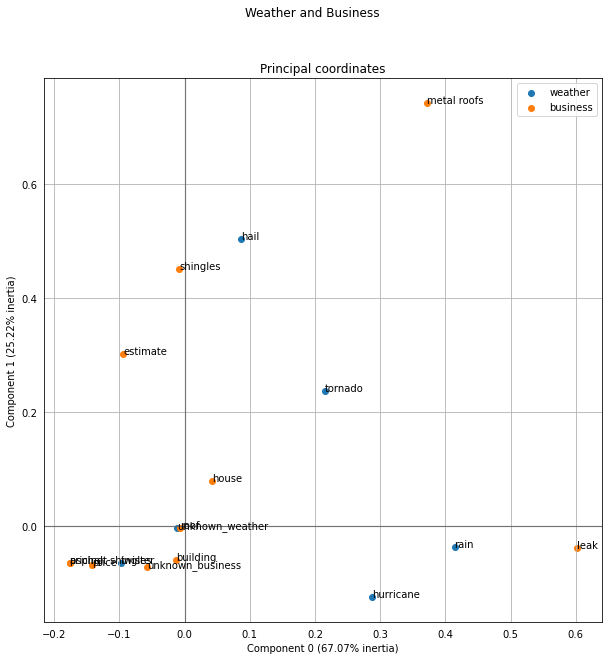

In [360]:
ax = ca.plot_coordinates(X=weather_business,ax=None,figsize=(10, 10),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)
plt = ax.get_figure()

plt.suptitle("Weather and Business ")

plt.savefig('mcp_image/weather_business.png')



'.'

                        0         1
hail            -0.066046  0.104273
hurricane        0.701790  0.151559
rain            -0.024163  0.065463
tornado         -0.065554  0.001750
twister         -0.062275  0.103162
unknown_weather  0.000622 -0.002509
                       0         1
corona         -0.009732 -0.173596
corona virus    0.029558 -0.177359
coronavirus     0.020571 -0.140688
covid           0.013945 -0.113646
pandemic        0.368676  0.017209
quote          -0.029808  0.007102
unknown_others -0.001311  0.001460
virus           0.014269 -0.114970


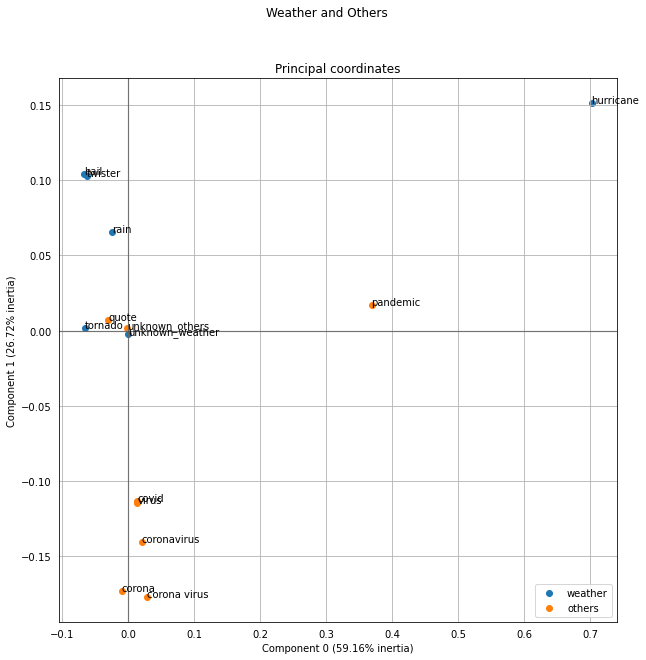

In [361]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(weather_others)
print(ca.row_coordinates(weather_others))
print(ca.column_coordinates(weather_others))
ax = ca.plot_coordinates(X=weather_others,ax=None,figsize=(10, 10),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)
plt = ax.get_figure()

plt.suptitle("Weather and Others ")
#plt.savefig('images/correspondence_analysis_CA/weather_business.png')
plt.savefig('mcp_image/weather_others.png')


                         0         1
asphalt shingles  0.006167  0.117939
building          0.018077  0.083409
estimate          0.433810 -0.024867
house             0.008795  0.053660
leak              0.026899 -0.058508
metal roofs       0.006167  0.117939
price            -0.034450 -0.015598
pricing           0.006167  0.117939
roof             -0.002672 -0.003962
shingles          0.271208  0.029432
unknown_business -0.032901  0.054239
                       0         1
corona         -0.049577 -0.173135
corona virus   -0.064510 -0.019746
coronavirus    -0.081662 -0.069084
covid          -0.089722 -0.130165
pandemic       -0.088826 -0.205026
quote           0.704397 -0.139694
unknown_others  0.000187  0.002156
virus          -0.131080  0.010707


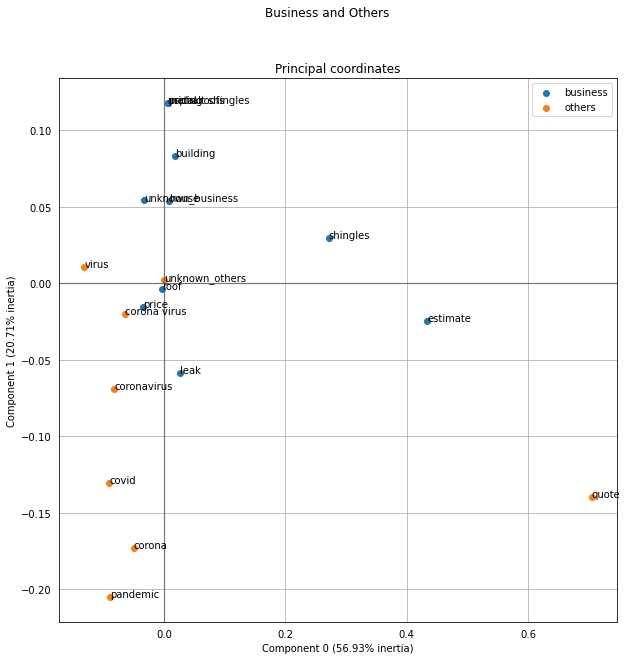

In [365]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(business_others)
print(ca.row_coordinates(business_others))
print(ca.column_coordinates(business_others))
ax = ca.plot_coordinates(X=business_others,ax=None,figsize=(10, 10),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)
plt = ax.get_figure()

plt.suptitle("Business and Others ")
#plt.savefig('images/correspondence_analysis_CA/weather_business.png')
plt.savefig('mcp_image/business_others.png')


                         0         1
asphalt shingles -0.170222  0.349703
building         -0.041199  0.001171
estimate          0.046993  0.224379
house            -0.034918 -0.008735
leak             -0.056481  0.002657
metal roofs      -0.191757  0.177704
price            -0.043993  0.166889
pricing          -0.170222  0.349703
roof             -0.006579 -0.002823
shingles         -0.057633  0.175028
unknown_business  0.410774  0.007430
                     0         1
good          0.288707  0.015805
like         -0.071898 -0.074178
love          0.198052 -0.043970
right        -0.029312 -0.046811
unknown_good -0.010578  0.007953
well          0.230874 -0.053185


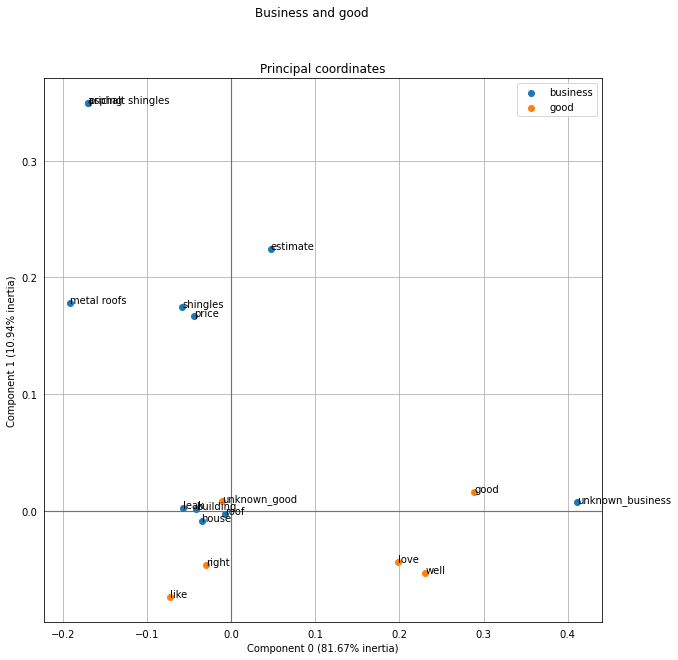

In [363]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(business_good)
print(ca.row_coordinates(business_good))
print(ca.column_coordinates(business_good))
ax = ca.plot_coordinates(X=business_good,ax=None,figsize=(10, 10),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)
plt = ax.get_figure()

plt.suptitle("Business and good ")
#plt.savefig('images/correspondence_analysis_CA/weather_business.png')
plt.savefig('mcp_image/good_business.png')


                         0         1
asphalt shingles  0.264935 -0.153226
building          0.218288 -0.049574
estimate          0.236996 -0.080494
house             0.147390  0.065216
leak              0.163349  0.113638
metal roofs       0.264935 -0.153226
price             0.207190  0.010808
pricing           0.102290  0.270181
roof             -0.020364 -0.001242
shingles          0.236925 -0.074002
unknown_business  0.231610 -0.055909
                    0         1
anxiety     -0.295263 -0.031017
cant        -0.089270  0.126863
dont        -0.055342  0.060810
unknown_bad  0.016784 -0.003315


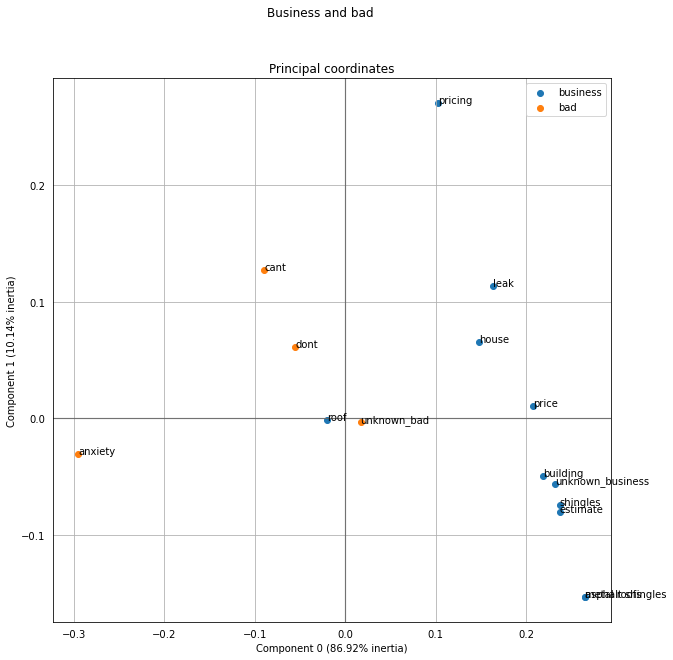

In [364]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(business_bad)
print(ca.row_coordinates(business_bad))
print(ca.column_coordinates(business_bad))
ax = ca.plot_coordinates(X=business_bad,ax=None,figsize=(10, 10),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)
plt = ax.get_figure()

plt.suptitle("Business and bad ")
#plt.savefig('images/correspondence_analysis_CA/weather_business.png')
plt.savefig('mcp_image/bad_business.png')


## Factor analysis

In [32]:
def find_state(s):
    if s is not None:
        for i in s.split(','):
            for j in i.split():
                if j.lower() in [k.lower() for k in usa_states]:
                    return usa_states_dict.get(j.lower(),j).upper()  
textdata['state_extracted']=textdata['user_location'].apply(find_state)

textdata.head(2)


,Author,Screenname,Created,text,place_name,country,place_type,user_location,user_geo_loc,tag,reply_to,Sentiment,rating,state_extracted,country_extracted,weather,business,good,bad,others
0,sweeterman,damydothedishes,2020-04-30 14:16:29,start roof,None,None,None,ATX,None,[],[],neutral,0.0,None,None,,roof,,,
1,Ahmed,Asheihab,2020-04-30 19:56:39,homemade stuff roof friends,None,None,None,CAI,None,[],['hawtstuffdotcom'],neutral,0.0,None,None,,roof,,,


vector shape (2960, 28)
(2960, 28)
loadings                 0         1         2         3         4
anxiety -0.080797  0.005473  0.616033  0.042940 -0.018803
back     0.047990 -0.009872  0.043050 -0.002069  0.019674
cant     0.005000 -0.009479  0.061126 -0.016429 -0.011643
car     -0.015653  0.012489 -0.011731 -0.024784  0.094669
dont     0.053805  0.126027  0.019918  0.101312  0.246134
food     0.610905 -0.040910  0.011101 -0.003403 -0.059396
get      0.002164  0.004332 -0.037574  0.143339  0.112501
good     0.102424  0.019331  0.076443 -0.012001  0.009851
head     0.616120 -0.036629  0.014450 -0.007136 -0.048113
home    -0.008157 -0.010218  0.015013  0.168732  0.030941
house   -0.013412 -0.019165 -0.074502  0.003096  0.038063
like    -0.026377 -0.043598 -0.002129 -0.048712  0.153542
mouth   -0.013649 -0.044154 -0.036108 -0.129547  0.037961
need     0.055889 -0.046837 -0.007790  0.294691 -0.007404
new     -0.038970 -0.036810 -0.089386  0.269721 -0.010673
people   0.067412  0.038671 

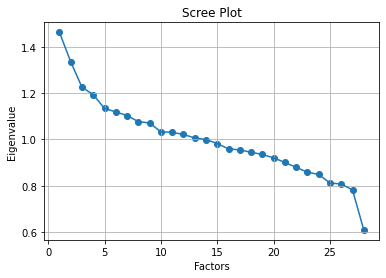

loadings                 0         1
anxiety -0.029491 -0.063431
back     0.051976 -0.008489
cant     0.013163 -0.020302
car     -0.002914 -0.067300
dont     0.042501 -0.029225
food     0.588272  0.180720
get     -0.024311  0.070433
good     0.108252 -0.007866
head     0.596099  0.170992
home    -0.042886  0.118330
house   -0.016376  0.000844
like    -0.002562 -0.107458
mouth    0.016894 -0.114334
need    -0.013801  0.255569
new     -0.105894  0.236096
people   0.061033 -0.032851
really   0.058522 -0.038126
right   -0.024540 -0.035036
roofing -0.130853  0.241570
solar   -0.035241 -0.000564
take    -0.093215  0.233739
think    0.002058 -0.045044
time     0.025436 -0.036057
today   -0.071932  0.137750
top     -0.073711  0.075845
want     0.032438 -0.028310
work     0.031499  0.170927
would   -0.006025 -0.049086
variance, proportional variance and cumulative variance for each factor (array([0.7812157 , 0.41372514]), array([0.02790056, 0.0147759 ]), array([0.02790056, 0.04267646]))


In [70]:
import warnings
warnings.filterwarnings('ignore')

count_vectorizer = CountVectorizer(min_df = 50, max_df=200, stop_words =['roof'])
# Fit and transform the processed text
count_data = count_vectorizer.fit_transform(textdata[textdata['state_extracted']=='CA']['text'])
print('vector shape',count_data.shape)
    
# convert count_vectorizer data to df
count_data_df = pd.DataFrame(count_data.todense(), columns=count_vectorizer.get_feature_names())
print(count_data_df.shape)

fa = FactorAnalyzer(rotation="varimax", n_factors = 5)
#fa.fit_transform(count_data.toarray(), 5)
fa.fit_transform(count_data_df)

#convert numpy array to dataframe
print('loadings',pd.DataFrame(fa.loadings_,index=count_data_df.columns))

print("variance, proportional variance and cumulative variance for each factor",fa.get_factor_variance())
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev
plt.scatter(range(1,count_data_df.shape[1]+1),ev)
plt.plot(range(1,count_data_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

fa = FactorAnalyzer(rotation="varimax", n_factors  = 2)
fa.fit_transform(count_data_df )
print('loadings',pd.DataFrame(fa.loadings_,index=count_data_df.columns))

print("variance, proportional variance and cumulative variance for each factor",fa.get_factor_variance())

In [69]:
#variance, proportional variance and cumulative variance for each factor
fa.get_factor_variance()

(array([0.7812157 , 0.41372514]),
 array([0.02790056, 0.0147759 ]),
 array([0.02790056, 0.04267646]))

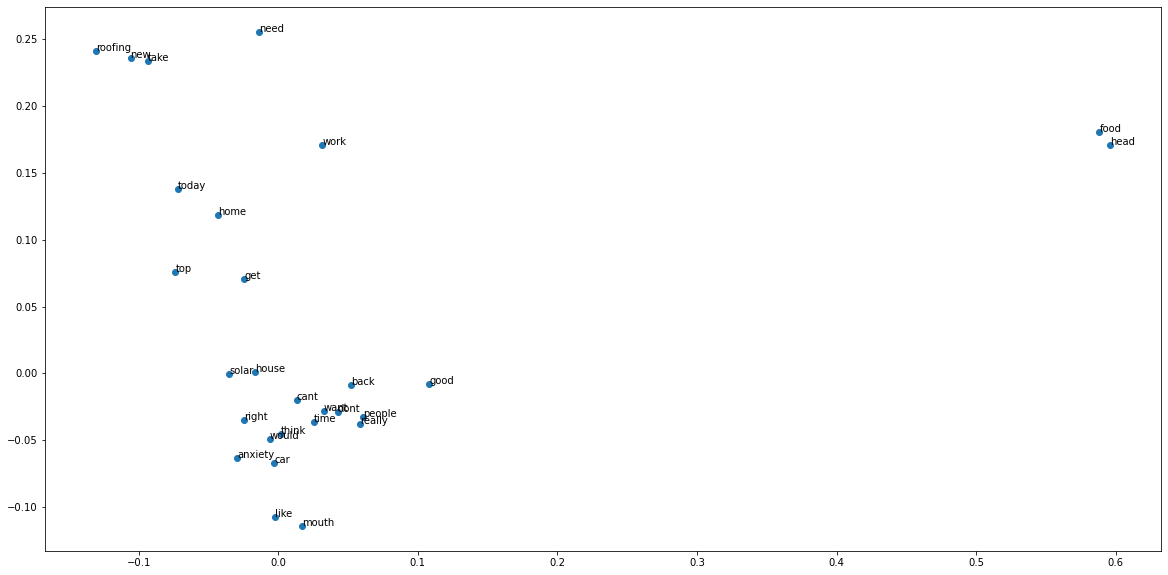

In [93]:
plotdf=pd.DataFrame(fa.loadings_,index=count_data_df.columns)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))

vals,poly = plotdf[plotdf.columns[0]].tolist(), plotdf[plotdf.columns[1]].tolist() 
n=plotdf.index.tolist()

ax.scatter(vals, poly)
#ax.set_xlim([0, .2])

for i, txt in enumerate(n):
    ax.annotate(txt, (vals[i], poly[i]))
    
plt.show()
